<a href="https://colab.research.google.com/github/walnashgit/S24-SD/blob/main/S24_SD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/walnashgit/S24-SD.git

Cloning into 'S24-SD'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 36 (delta 13), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (36/36), 2.01 MiB | 13.74 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
%cd /content/S24-SD

/content/S24-SD


In [3]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.6 MB/s eta 0:00:00


In [4]:
# For video display:
from pathlib import Path

import torch
from huggingface_hub import notebook_login
from transformers import logging

from utils import (tokenizer, text_encoder, torch_device, generate_with_embs,
                   get_output_embeds, plot_image, get_image_as_per_style_and_prompt)


if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.7.layer_norm2.weight', 'vision_model.encoder.layers.6.mlp.fc2.bias', 'vision_model.encoder.layers.22.self_attn.q_proj.weight', 'vision_model.encoder.layers.6.layer_norm1.weight', 'vision_model.encoder.layers.15.self_attn.out_proj.weight', 'vision_model.encoder.layers.16.self_attn.q_proj.weight', 'vision_model.encoder.layers.4.self_attn.k_proj.bias', 'vision_model.encoder.layers.20.layer_norm1.weight', 'vision_model.encoder.layers.7.mlp.fc1.weight', 'vision_model.encoder.layers.2.self_attn.q_proj.weight', 'vision_model.encoder.layers.19.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.self_attn.v_proj.bias', 'vision_model.encoder.layers.23.self_attn.k_proj.weight', 'vision_model.encoder.layers.3.self_attn.v_proj.bias', 'vision_model.encoder.layers.7.self_attn.q_proj.weight', 'vision_model.encoder.layers.8.self_attn.out_proj.bias', 'visi

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

/content/S24-SD/utils.py:108: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

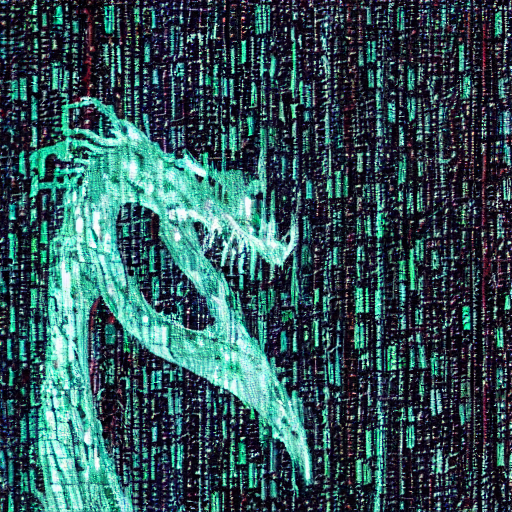

In [11]:
from utils import get_image_as_per_style_and_prompt

prompt = 'oil painting of a dragon in puppy style'
style = 'learned_embeds_matrix.bin'
seed = 30

image = get_image_as_per_style_and_prompt(prompt, style, seed)
image


In [9]:
# Custom loss function
def reduce_highlight(images):
    # Convert to float32 for processing and normalize to [0, 1]
    images_float = images.float() / 255.0

    # Apply highlight reduction
    highlight_reduction_factor = 0.5
    highlight_threshold = 0.8

    # Reduce highlights
    mask = images_float > highlight_threshold
    images_float[mask] *= highlight_reduction_factor

    # Convert back to uint8 and denormalize
    images_output = (images_float * 255).clamp(0, 255).byte()
    error = torch.abs(images - images_output).mean()
    return error

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 10.723936080932617
10 loss: 10.876863479614258
20 loss: 10.326128959655762


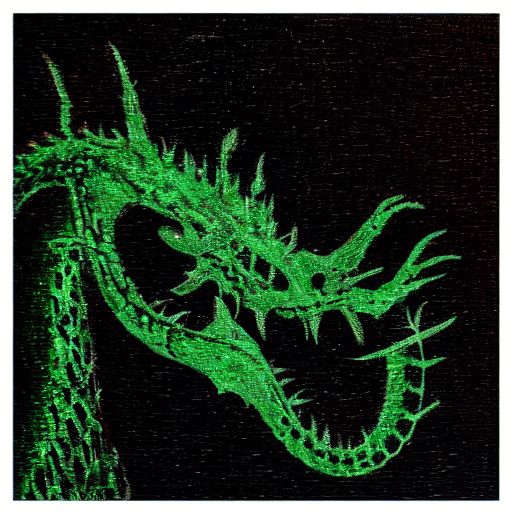

In [10]:
from utils import get_image_as_per_style_and_prompt

prompt = 'oil painting of a dragon in puppy style'
style = 'learned_embeds_matrix.bin'
seed = 30

image = get_image_as_per_style_and_prompt(prompt, style, seed, reduce_highlight)
image

  0%|          | 0/30 [00:00<?, ?it/s]

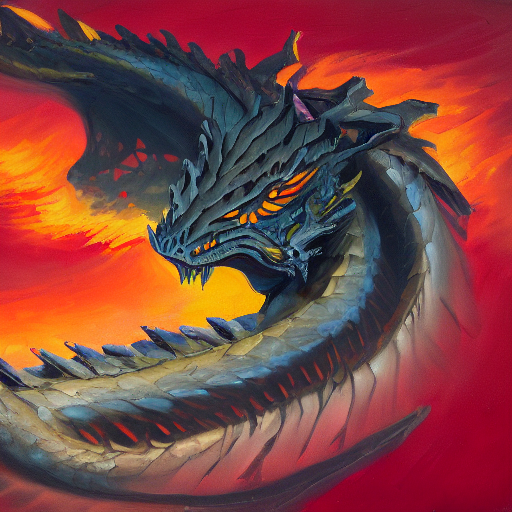

In [14]:
from utils import get_image_as_per_style_and_prompt

prompt = 'oil painting of a dragon in puppy style'
style = 'learned_embeds_mosiac.bin'
seed = 40

image = get_image_as_per_style_and_prompt(prompt, style, seed)
image

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 18.761457443237305
10 loss: 8.716076850891113
20 loss: 8.954679489135742


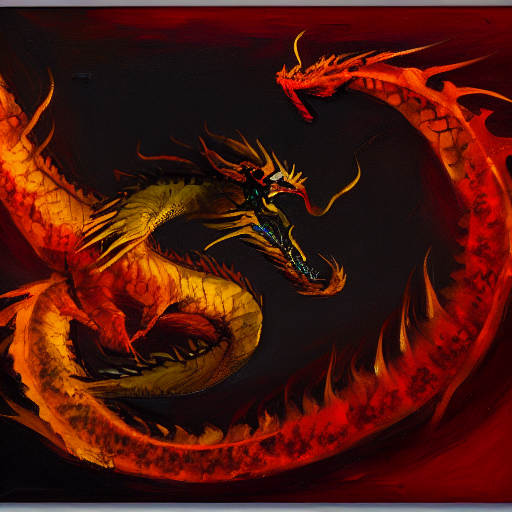

In [13]:
from utils import get_image_as_per_style_and_prompt

prompt = 'oil painting of a dragon in puppy style'
style = 'learned_embeds_mosiac.bin'
seed = 40

image = get_image_as_per_style_and_prompt(prompt, style, seed, reduce_highlight)
image

  0%|          | 0/30 [00:00<?, ?it/s]

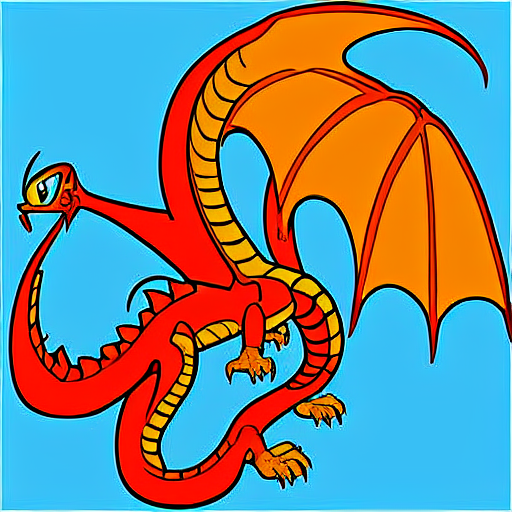

In [17]:
from utils import get_image_as_per_style_and_prompt

prompt = 'oil painting of a dragon in puppy style'
style = 'learned_embeds_pokemon.bin'
seed = 50

image = get_image_as_per_style_and_prompt(prompt, style, seed)
image

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 24.405811309814453
10 loss: 17.4747314453125
20 loss: 15.878368377685547


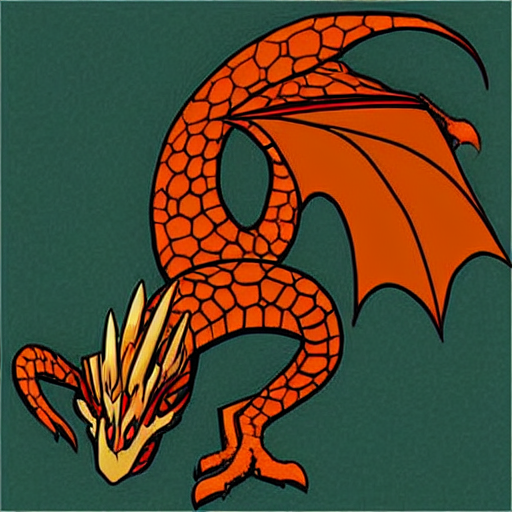

In [16]:
from utils import get_image_as_per_style_and_prompt

prompt = 'oil painting of a dragon in puppy style'
style = 'learned_embeds_pokemon.bin'
seed = 50

image = get_image_as_per_style_and_prompt(prompt, style, seed, reduce_highlight)
image

  0%|          | 0/30 [00:00<?, ?it/s]

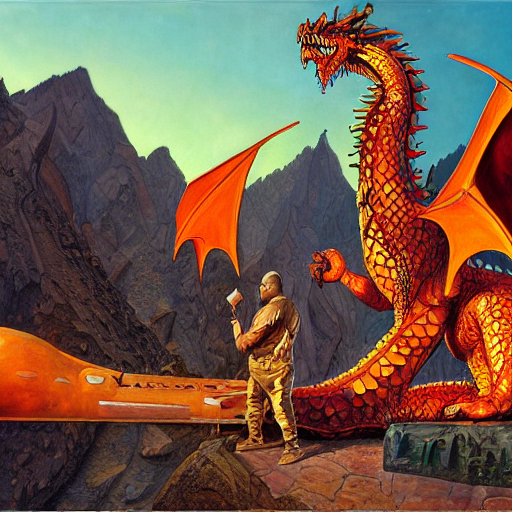

In [21]:
from utils import get_image_as_per_style_and_prompt

prompt = 'oil painting of a dragon in puppy style'
style = 'learned_embeds_mobious.bin'
seed = 60

image = get_image_as_per_style_and_prompt(prompt, style, seed)
image

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 17.96041488647461
10 loss: 12.619293212890625
20 loss: 11.715972900390625


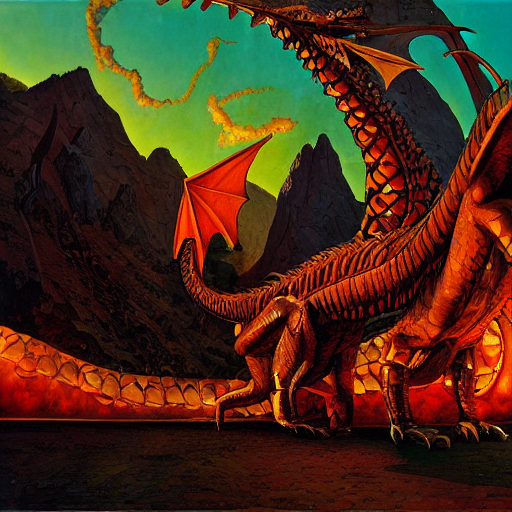

In [18]:
from utils import get_image_as_per_style_and_prompt

prompt = 'oil painting of a dragon in puppy style'
style = 'learned_embeds_mobious.bin'
seed = 60

image = get_image_as_per_style_and_prompt(prompt, style, seed, reduce_highlight)
image

  0%|          | 0/30 [00:00<?, ?it/s]

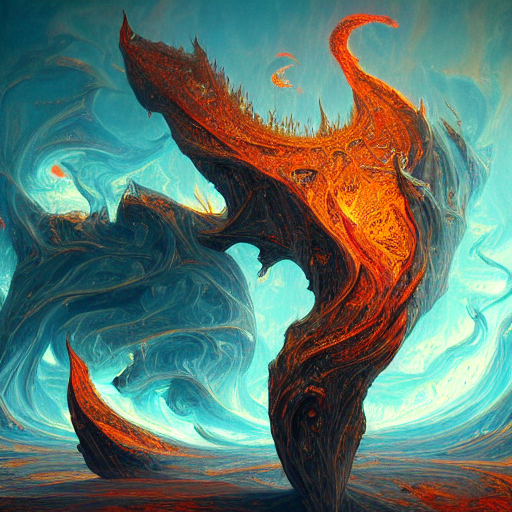

In [23]:
from utils import get_image_as_per_style_and_prompt

prompt = 'oil painting of a dragon in puppy style'
style = 'learned_embeds_midj.bin'
seed = 70

image = get_image_as_per_style_and_prompt(prompt, style, seed)
image

  0%|          | 0/30 [00:00<?, ?it/s]

0 loss: 25.742488861083984
10 loss: 13.31229019165039
20 loss: 12.651949882507324


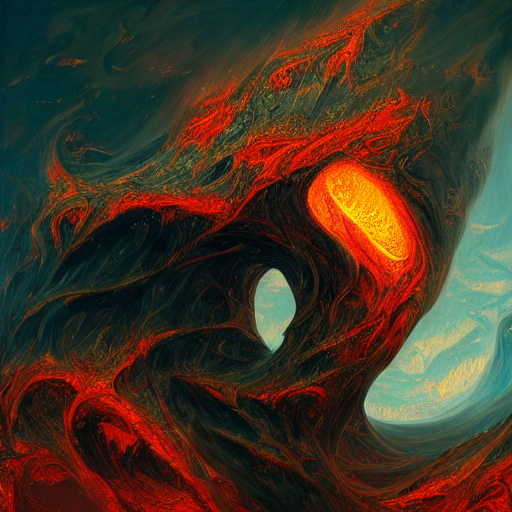

In [22]:
from utils import get_image_as_per_style_and_prompt

prompt = 'oil painting of a dragon in puppy style'
style = 'learned_embeds_midj.bin'
seed = 70

image = get_image_as_per_style_and_prompt(prompt, style, seed, reduce_highlight)
image